In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package punkt to /home/sultan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sultan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sultan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/sultan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print(type(STOPWORDS))

<class 'list'>


In [4]:
import re, string 
import pandas as pd   
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
%matplotlib inline

df = pd.read_csv('bbc_data.csv')
df.columns= ['news_article'] 
def clean_text(text):
    '''Make text lowercase, remove square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'[\[\]\(\)\{\}]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    text = word_tokenize(text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return [word for word in text if word not in STOPWORDS]

tokenized_corpus = df['news_article'].apply(lambda x: clean_text(x))
print(tokenized_corpus)

0       [claxton, hunting, first, major, medal, britis...
1       [osullivan, could, run, worlds, sonia, osulliv...
2       [greene, sets, sights, world, title, maurice, ...
3       [iaaf, launches, fight, drugs, iaaf, athletics...
4       [dibaba, breaks, world, record, ethiopias, tir...
                              ...                        
2220    [trial, begins, spains, top, banker, trial, em...
2221    [uk, economy, ends, year, spurt, uk, economy, ...
2222    [healthsouth, exboss, goes, trial, former, hea...
2223    [euro, firms, miss, optimism, large, companies...
2224    [lacroix, label, bought, us, firm, luxury, goo...
Name: news_article, Length: 2225, dtype: object


In [5]:
print(tokenized_corpus[0])
print(type(tokenized_corpus[0][0]))

['claxton', 'hunting', 'first', 'major', 'medal', 'british', 'hurdler', 'sarah', 'claxton', 'confident', 'win', 'first', 'major', 'medal', 'next', 'months', 'european', 'indoor', 'championships', 'madrid', 'already', 'smashed', 'british', 'record', 'hurdles', 'twice', 'season', 'setting', 'new', 'mark', 'seconds', 'win', 'aaas', 'title', 'quite', 'confident', 'said', 'claxton', 'take', 'race', 'comes', 'long', 'keep', 'training', 'much', 'think', 'chance', 'medal', 'claxton', 'national', 'hurdles', 'title', 'past', 'three', 'years', 'struggled', 'translate', 'domestic', 'success', 'international', 'stage', 'scotlandborn', 'athlete', 'owns', 'equal', 'fifthfastest', 'time', 'world', 'year', 'last', 'weeks', 'birmingham', 'grand', 'prix', 'claxton', 'left', 'european', 'medal', 'favourite', 'russian', 'irina', 'shevchenko', 'trailing', 'sixth', 'spot', 'first', 'time', 'claxton', 'preparing', 'campaign', 'hurdles', 'could', 'explain', 'leap', 'form', 'previous', 'seasons', 'also', 'conte

In [6]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [7]:
vocabulary_size

31300

In [8]:
word2idx

{'claxton': 0,
 'hunting': 1,
 'first': 2,
 'major': 3,
 'medal': 4,
 'british': 5,
 'hurdler': 6,
 'sarah': 7,
 'confident': 8,
 'win': 9,
 'next': 10,
 'months': 11,
 'european': 12,
 'indoor': 13,
 'championships': 14,
 'madrid': 15,
 'already': 16,
 'smashed': 17,
 'record': 18,
 'hurdles': 19,
 'twice': 20,
 'season': 21,
 'setting': 22,
 'new': 23,
 'mark': 24,
 'seconds': 25,
 'aaas': 26,
 'title': 27,
 'quite': 28,
 'said': 29,
 'take': 30,
 'race': 31,
 'comes': 32,
 'long': 33,
 'keep': 34,
 'training': 35,
 'much': 36,
 'think': 37,
 'chance': 38,
 'national': 39,
 'past': 40,
 'three': 41,
 'years': 42,
 'struggled': 43,
 'translate': 44,
 'domestic': 45,
 'success': 46,
 'international': 47,
 'stage': 48,
 'scotlandborn': 49,
 'athlete': 50,
 'owns': 51,
 'equal': 52,
 'fifthfastest': 53,
 'time': 54,
 'world': 55,
 'year': 56,
 'last': 57,
 'weeks': 58,
 'birmingham': 59,
 'grand': 60,
 'prix': 61,
 'left': 62,
 'favourite': 63,
 'russian': 64,
 'irina': 65,
 'shevchenko'

In [9]:
window_size = 3
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

In [10]:
idx_pairs[:10]

array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 0],
       [1, 2],
       [1, 3],
       [1, 4],
       [2, 0],
       [2, 1],
       [2, 3]])

In [9]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x
  
#Input layer is just the center word encoded in one-hot manner. It dimensions are [1, vocabulary_size]

In [10]:
embedding_dims = 5
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 100
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.data.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    if epo % 10 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

KeyboardInterrupt: 

Word2Vec

In [11]:
df_clean = pd.DataFrame(tokenized_corpus)
df_clean

,news_article
0,"[claxton, hunting, first, major, medal, britis..."
1,"[osullivan, could, run, worlds, sonia, osulliv..."
2,"[greene, sets, sights, world, title, maurice, ..."
3,"[iaaf, launches, fight, drugs, iaaf, athletics..."
4,"[dibaba, breaks, world, record, ethiopias, tir..."
...,...
2220,"[trial, begins, spains, top, banker, trial, em..."
2221,"[uk, economy, ends, year, spurt, uk, economy, ..."
2222,"[healthsouth, exboss, goes, trial, former, hea..."
2223,"[euro, firms, miss, optimism, large, companies..."


In [17]:
nlp = spacy.load('en')
df_clean = pd.DataFrame(tokenized_corpus)
def lemmatizer(text):        
    sent = []
    doc = nlp(" ".join(text))
    for word in doc:
        sent.append(word.lemma_)
    return sent

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['news_article']), axis=1)

In [18]:
df_clean

,news_article,text_lemmatize
0,"[claxton, hunting, first, major, medal, britis...","[claxton, hunt, first, major, medal, british, ..."
1,"[osullivan, could, run, worlds, sonia, osulliv...","[osullivan, could, run, world, sonia, osulliva..."
2,"[greene, sets, sights, world, title, maurice, ...","[greene, set, sight, world, title, maurice, gr..."
3,"[iaaf, launches, fight, drugs, iaaf, athletics...","[iaaf, launch, fight, drug, iaaf, athletic, wo..."
4,"[dibaba, breaks, world, record, ethiopias, tir...","[dibaba, break, world, record, ethiopia, tirun..."
...,...,...
2220,"[trial, begins, spains, top, banker, trial, em...","[trial, begin, spain, top, banker, trial, emil..."
2221,"[uk, economy, ends, year, spurt, uk, economy, ...","[uk, economy, end, year, spurt, uk, economy, g..."
2222,"[healthsouth, exboss, goes, trial, former, hea...","[healthsouth, exboss, go, trial, former, head,..."
2223,"[euro, firms, miss, optimism, large, companies...","[euro, firm, miss, optimism, large, company, a..."


In [19]:
sentences = [row for row in df_clean['text_lemmatize']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 '-PRON-',
 'mr',
 'year',
 'would',
 'make',
 'also',
 'people',
 'new',
 'one']

In [20]:
import sys
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

/home/sultan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [21]:
w2v_model.wv.most_similar(positive=['people'])

[('let', 0.9710507392883301),
 ('create', 0.9241900444030762),
 ('different', 0.9237654209136963),
 ('important', 0.9127494096755981),
 ('mean', 0.911490261554718),
 ('able', 0.9082561731338501),
 ('way', 0.9069901704788208),
 ('work', 0.900853157043457),
 ('like', 0.8873452544212341),
 ('rather', 0.8779913783073425)]

In [22]:
w2v_model.wv.similarity('company', 'business')

0.82619077

In [30]:
voc = list(w2v_model.wv.vocab)
print(len(voc))
print(voc)


496
['first', 'major', 'british', 'win', 'next', 'month', 'european', 'already', 'record', 'season', 'set', 'new', 'mark', 'second', 'title', 'say', 'take', 'race', 'come', 'long', 'keep', 'much', 'think', 'chance', 'national', 'past', 'three', 'year', 'success', 'international', 'time', 'world', 'last', 'week', 'leave', 'campaign', 'could', 'form', 'also', 'since', 'move', 'london', 'see', 'pay', 'place', 'march', 'run', 'would', 'like', 'country', 'ireland', 'may', 'include', 'official', 'event', 'france', 'team', 'saturday', 'announce', 'base', 'boost', 'likely', 'part', 'great', 'aim', 'lose', 'olympic', 'behind', 'american', 'really', 'look', 'thing', 'friday', 'never', 'go', 'happen', 'goal', '-PRON-', 'be', 'line', 'one', 'believe', 'that', 's', 'third', 'do', 'not', 'know', 'put', 'final', 'feel', 'able', 'people', 'ahead', 'deny', 'britain', 'star', 'union', 'currently', 'hold', 'another', 'meeting', 'big', 'face', 'always', 'young', 'have', 'get', 'five', 'six', 'launch', 'fi

In [24]:
w2v_model.wv.most_similar(positive=['US'])

KeyError: "word 'US' not in vocabulary"

In [31]:
sentences_full = [row for row in df_clean['news_article']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
        
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 '-PRON-',
 'mr',
 'year',
 'would',
 'make',
 'also',
 'people',
 'new',
 'one']

In [32]:
import sys
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=500,
                     workers=4)
                     
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

/home/sultan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [33]:
voc = list(w2v_model.wv.vocab)
print(len(voc))
print(voc)

5365
['claxton', 'hunt', 'first', 'major', 'medal', 'british', 'sarah', 'confident', 'win', 'next', 'month', 'european', 'indoor', 'championship', 'madrid', 'already', 'smash', 'record', 'hurdle', 'twice', 'season', 'set', 'new', 'mark', 'second', 'aaas', 'title', 'quite', 'say', 'take', 'race', 'come', 'long', 'keep', 'train', 'much', 'think', 'chance', 'national', 'past', 'three', 'year', 'struggle', 'translate', 'domestic', 'success', 'international', 'stage', 'athlete', 'own', 'equal', 'time', 'world', 'last', 'week', 'birmingham', 'grand', 'prix', 'leave', 'favourite', 'russian', 'trail', 'sixth', 'spot', 'prepare', 'campaign', 'could', 'explain', 'leap', 'form', 'previous', 'also', 'contest', 'jump', 'since', 'move', 'london', 'attention', 'see', 'training', 'regime', 'pay', 'dividend', 'place', 'march', 'osullivan', 'run', 'indicate', 'would', 'like', 'participate', 'cross', 'country', 'st', 'athletic', 'ireland', 'hint', 'runner', 'may', 'include', 'official', 'lineup', 'event'

In [34]:
w2v_model.wv.most_similar(positive=['people'])

[('need', 0.9597951173782349),
 ('way', 0.9590937495231628),
 ('money', 0.9563276767730713),
 ('mean', 0.9474747776985168),
 ('able', 0.9376639723777771),
 ('work', 0.9339637160301208),
 ('make', 0.9231633543968201),
 ('want', 0.922881543636322),
 ('device', 0.9228551983833313),
 ('let', 0.922608494758606)]

In [35]:
w2v_model.wv.similarity('company', 'business')

0.78352827

In [36]:
w2v_model.wv.most_similar(positive=['america'])

[('comprise', 0.9979450702667236),
 ('hong', 0.9976969361305237),
 ('kong', 0.9974295496940613),
 ('amsterdam', 0.9958415031433105),
 ('raid', 0.9953607320785522),
 ('burger', 0.9951891899108887),
 ('among', 0.9951043128967285),
 ('ronan', 0.9942792654037476),
 ('denmark', 0.9940423965454102),
 ('industrialise', 0.9940322637557983)]

/home/sultan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


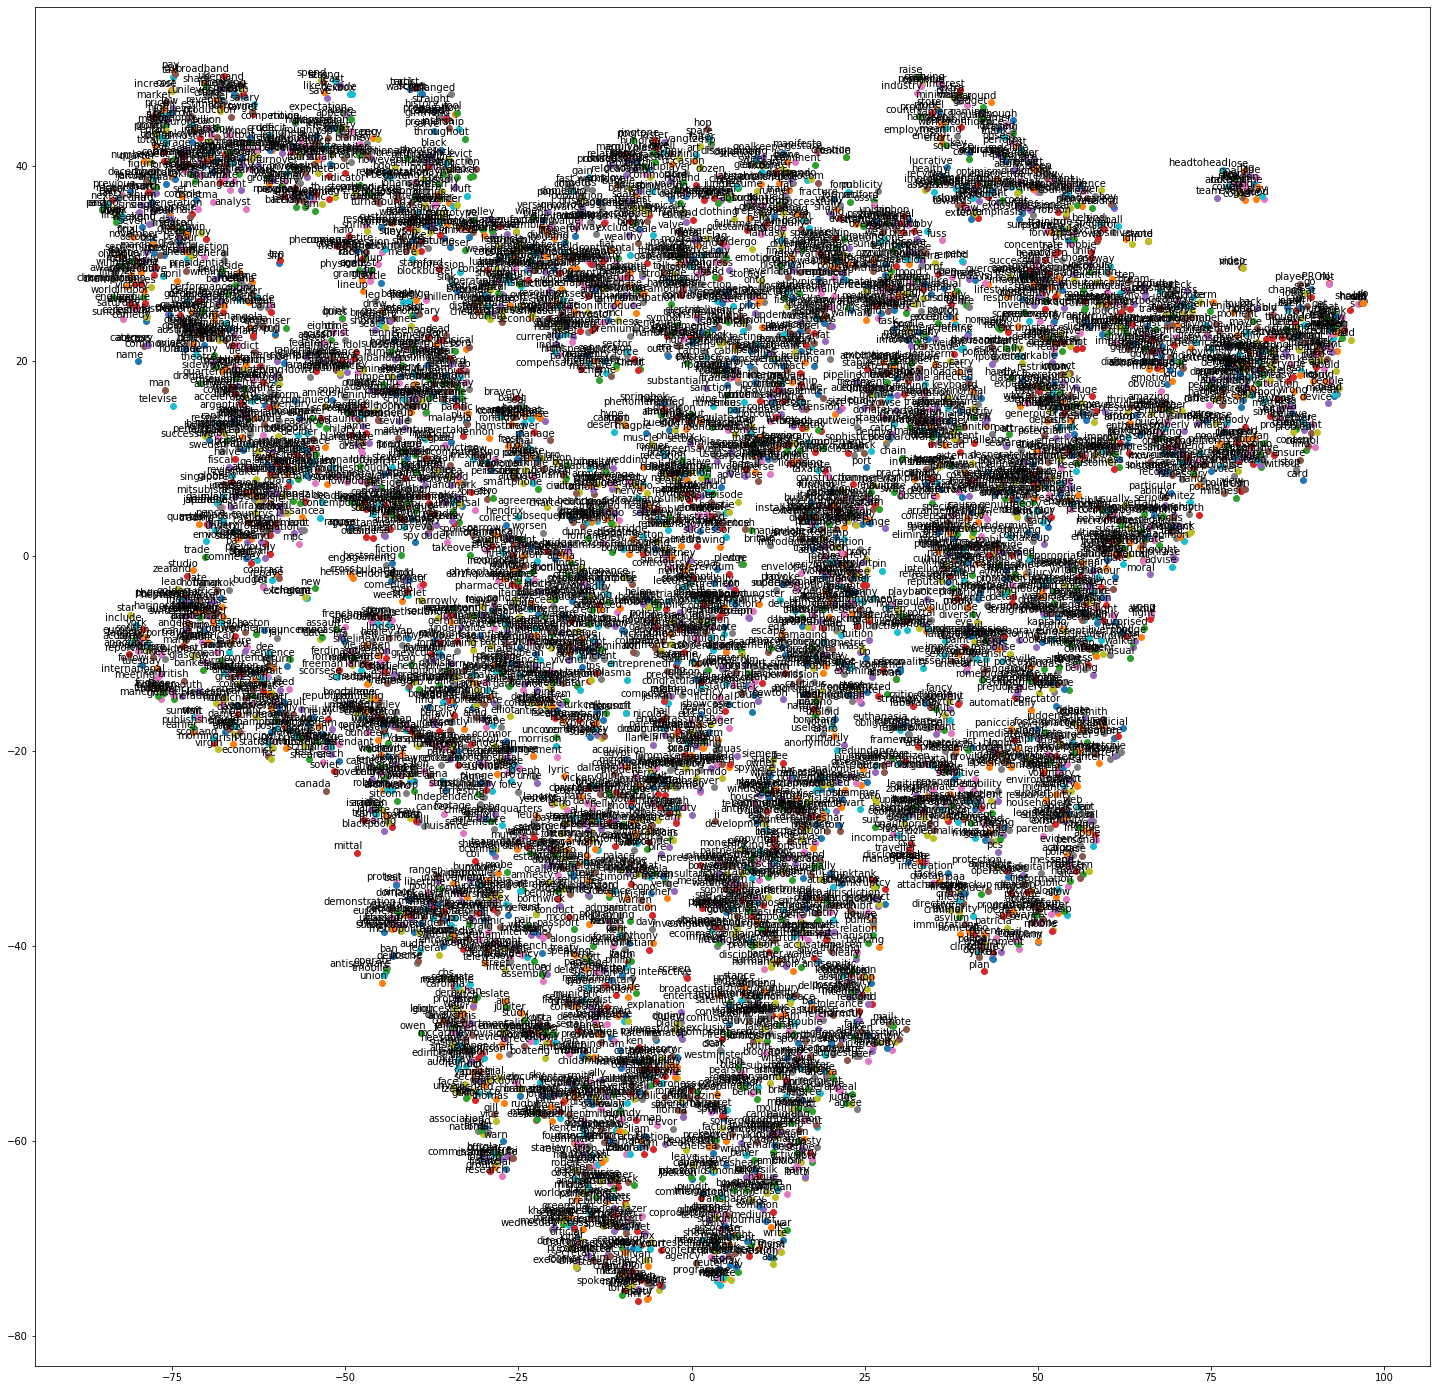

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
   
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    # print(x, y)        
    plt.figure(figsize=(25,25)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)

In [40]:
vector = w2v_model.wv['america']  # numpy vector of a word
print(len(vector))
print(vector)

500
[ 2.92319711e-02 -4.92078904e-03  5.00835106e-02  1.04883224e-01
  9.07911826e-03 -4.24899459e-02  4.63951156e-02  4.28512767e-02
  1.00260712e-02  4.89943884e-02  1.92024722e-03 -3.56410928e-02
 -5.31789660e-02  2.22721454e-02  6.60533383e-02 -5.77087849e-02
 -1.17428284e-02 -4.57500741e-02  6.64884457e-03  8.82336637e-04
 -2.74286382e-02  3.74302976e-02  2.62293499e-02 -1.75552443e-02
 -6.43700063e-02  9.01782885e-02 -1.12357758e-01  1.91158019e-02
 -5.70506789e-02  5.34128658e-02 -1.49867386e-01 -7.37619475e-02
 -3.94515023e-02 -4.40378524e-02  6.64985925e-02 -2.66095493e-02
  3.94687429e-02  2.48918012e-02  4.49535716e-03 -3.69164022e-03
  1.45250792e-03  1.31813148e-02  7.13121817e-02 -7.40469713e-03
  3.72762494e-02  1.34612955e-02  9.73722115e-02  6.17946163e-02
  1.96353029e-02 -3.92409377e-02  1.48206288e-02 -3.97313852e-03
  5.99526688e-02  3.19833830e-02 -6.91858977e-02 -5.31759299e-02
  5.30426428e-02 -4.33597676e-02  7.13491812e-02  3.53273228e-02
  7.00222105e-02  4.2